## Model Evaluation

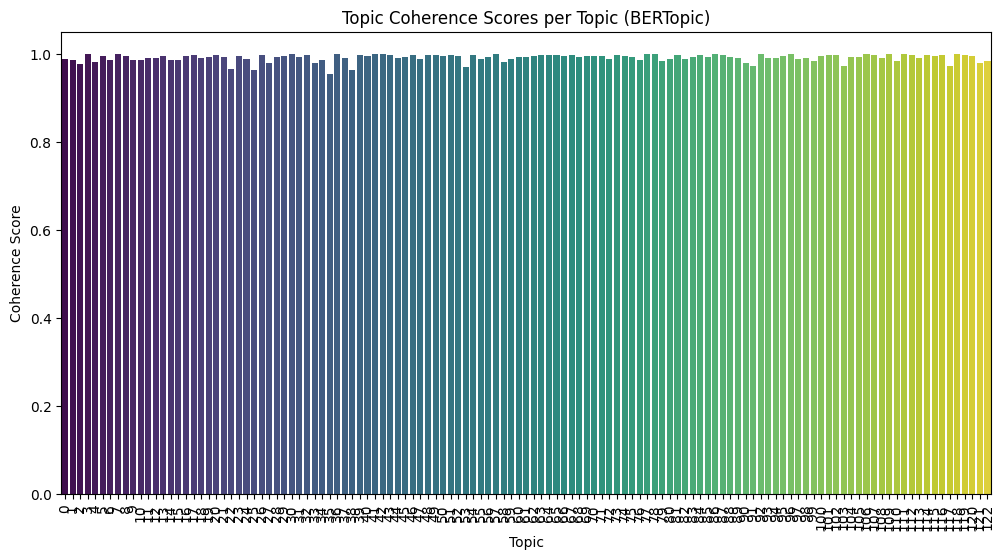

In [8]:
import pandas as pd
import joblib
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

model_path = "../Model-training/bertopic_model_multi.pkl"
# topic_model = joblib.load(model_path)
with open(model_path, 'rb') as file:
    topic_model = pickle.load(file)

df = pd.read_csv("../Model-training/topic_modeling_results_multi.csv")

topics = df["topics"].unique()
topics = [topic for topic in topics if topic != -1] # Menghilangkan topik -1 (noise)

# Mendapatkan kata-kata utama dari setiap topik
topic_words = {topic: topic_model.get_topic(topic) for topic in topics}
topic_word_list = [[word for word, _ in topic_words[topic]] for topic in topic_words]

# Membuat dictionary dan corpus untuk coherence calculation
dictionary = Dictionary(topic_word_list)
corpus = [dictionary.doc2bow(words) for words in topic_word_list]

# Menghitung coherence score untuk setiap topik
coherence_scores = []
for words in topic_word_list:
    cm = CoherenceModel(
        topics=[words], 
        texts=topic_word_list, 
        dictionary=dictionary, 
        coherence="c_v"  # Bisa diganti dengan 'u_mass', 'c_uci', atau 'c_npmi'
    )
    coherence_scores.append(cm.get_coherence())

# Membuat DataFrame untuk plotting
coherence_df = pd.DataFrame({
    "Topic": list(topic_words.keys()),
    "Coherence": coherence_scores
})

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=coherence_df, x="Topic", y="Coherence", palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Topic")
plt.ylabel("Coherence Score")
plt.title("Topic Coherence Scores per Topic (BERTopic)")
plt.show()

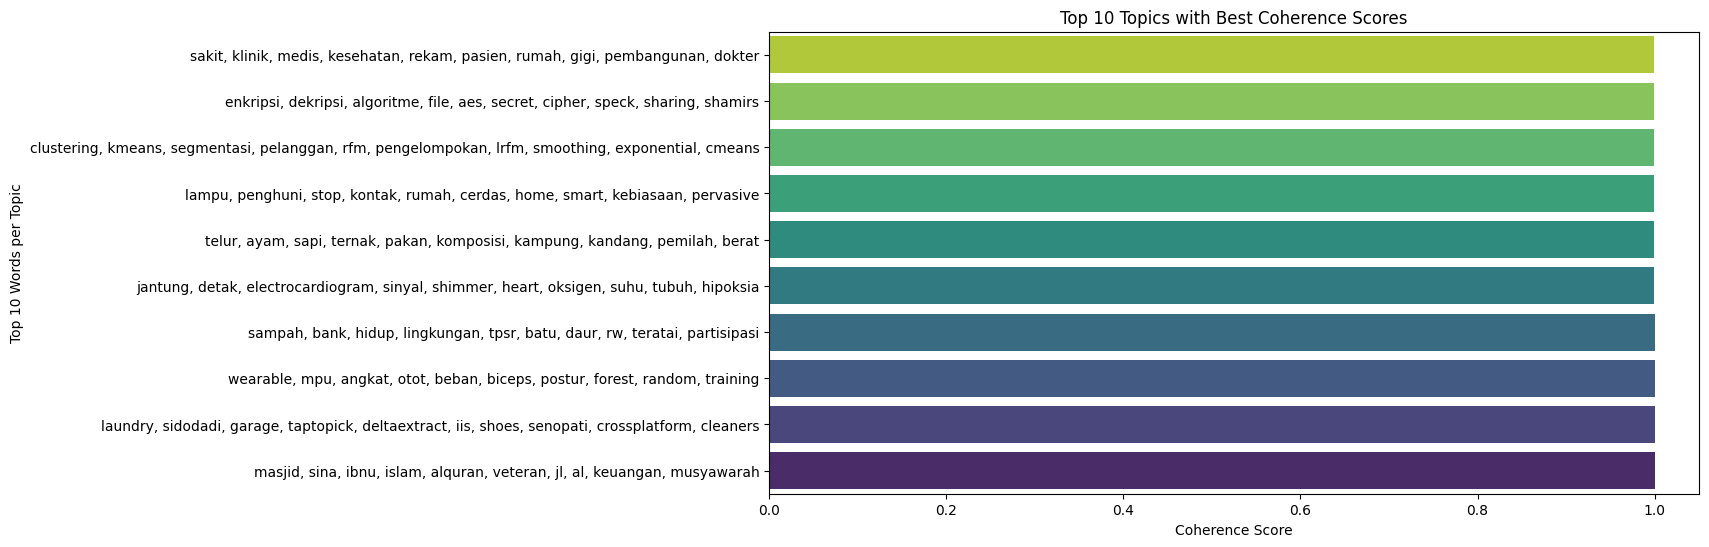

In [9]:
top_10_topics = coherence_df.nlargest(10, "Coherence")

top_10_topics["Top Words"] = [
    ", ".join([word for word, _ in topic_words[topic]][:10])  # Ambil 10 kata pertama
    for topic in top_10_topics["Topic"]
]

# Plot  
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_topics, x="Coherence", y="Top Words", palette="viridis")
plt.xlabel("Coherence Score")
plt.ylabel("Top 10 Words per Topic")
plt.title("Top 10 Topics with Best Coherence Scores")
plt.gca().invert_yaxis()
plt.show()

In [21]:
topic_model.get_topic(-1)

[('berbasis', 0.00784729214141606),
 ('pengembangan', 0.007840052117481126),
 ('aplikasi', 0.007827673805213823),
 ('perancangan', 0.007444257548315922),
 ('sistem', 0.007326158242912421),
 ('design', 0.007002390676080843),
 ('studi', 0.006899506959142593),
 ('web', 0.006723246344767719),
 ('metode', 0.00651260126428132),
 ('malang', 0.00616630592878895)]

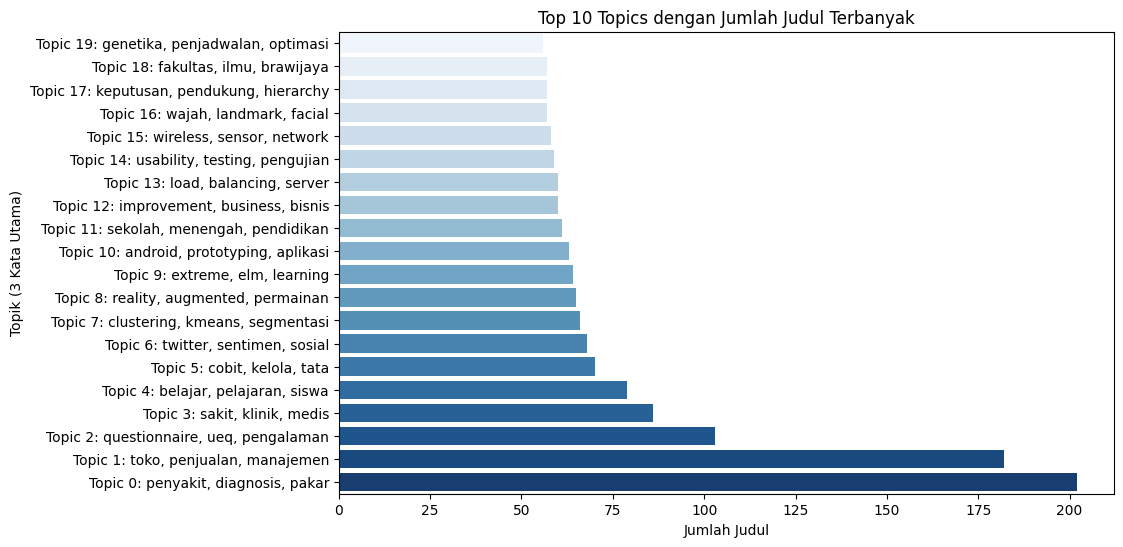

In [23]:
# Hitung jumlah judul per topik
df = df[df["topics"] != -1]
topic_counts = df["topics"].value_counts().reset_index()
topic_counts.columns = ["Topic", "Count"]

# Ambil top 10 topik dengan jumlah judul terbanyak
top_10_topics = topic_counts.nlargest(20, "Count")

# Ambil 3 kata utama per topik untuk label
top_10_topics["Label"] = [
    f"Topic {topic_id}: " + ", ".join([word for word, _ in topic_model.get_topic(topic_id)][:3])  # ID + 3 kata utama
    for topic_id in top_10_topics["Topic"]
]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=top_10_topics, x="Count", y="Label", palette="Blues_r")
plt.xlabel("Jumlah Judul")
plt.ylabel("Topik (3 Kata Utama)")
plt.title("Top 10 Topics dengan Jumlah Judul Terbanyak")
plt.gca().invert_yaxis()
plt.show()